# CIS 5200: Machine Learning
## Homework 2

In [80]:
import os
import sys

# For autograder only, do not modify this cell. 
# True for Google Colab, False for autograder
NOTEBOOK = (os.getenv('IS_AUTOGRADER') is None)
if NOTEBOOK:
    print("[INFO, OK] Google Colab.")
else:
    print("[INFO, OK] Autograder.")
    sys.exit()

[INFO, OK] Google Colab.


### Penngrader setup

In [81]:
# %%capture
!pip install penngrader-client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [82]:
%%writefile config.yaml
grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'

Overwriting config.yaml


In [83]:
from penngrader.grader import PennGrader

# PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO 
# TO ASSIGN POINTS TO YOU IN OUR BACKEND
STUDENT_ID = 38513713 # YOUR PENN-ID GOES HERE AS AN INTEGER #
SECRET = STUDENT_ID

grader = PennGrader('config.yaml', 'CIS5200_23Sp_HW2', STUDENT_ID, SECRET)

PennGrader initialized with Student ID: 38513713

Make sure this correct or we will not be able to store your grade


In [84]:
# packages for homework
import torch
import torch.nn.functional as F
from PIL import Image
import torchvision
from torchvision import transforms as T
from torch.distributions.multivariate_normal import MultivariateNormal

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

def plot_helper(X, n0=4): 
    fig, axs = plt.subplots(n0, n0, figsize=(8,8))
    for i in range(n0*n0): 
        axs[i%n0,i//n0].imshow(X[i].view(32,32), cmap='gray')
        axs[i%n0,i//n0].axis('off')

# X-Ray data

For this part of the assignment, we'll be using some [x-ray data from the UCI repository](https://archive.ics.uci.edu/ml/datasets/Shoulder+Implant+X-Ray+Manufacturer+Classification). These are images of shoulder implants from four different manufacturers, sometimes with the same patient. Wouldn't it be nice if we could somehow group these images by patient, manufacturer, or some other pattern? We're going to try to cluster these x-rays and see what kinds of underlying structures we can discover. 

The following cells download and parse the data, and plots a couple examples. 

In [85]:
%%capture
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00517/data.zip
!unzip -o data.zip

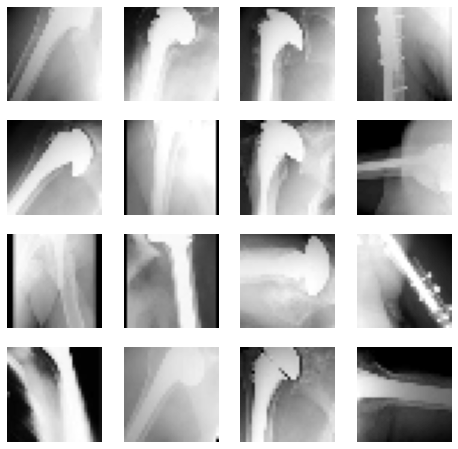

In [86]:
t = T.Compose([T.Resize(64),T.CenterCrop(32)])

data_path = 'data'
filenames = [name for name in os.listdir(data_path) if os.path.splitext(name)[-1] == '.jpg']
imgs =[torchvision.io.read_image(os.path.join(data_path,f)) for f in filenames]
imgs = torch.stack([t(im).float()/255 for im in imgs]).mean(1)
X = imgs.view(imgs.size(0),-1)

plot_helper(X)

# 1. K Means (7pts)

In this first problem, you'll implement the K-Means algorithm. Implement the following functions:

+ Init (2pts) - Given a batch of examples  $X$ and a number $k$, return an intial $k$ clusters using the K-means initialization. 
+ Assign clusters (2pts) - Given a batch of examples $X$ and cluster centroid estimates $\mu$, assign each example to the cluster with the closest centroid. 
+ Update centroids (2pts) - Given a batch of examples $X$ and cluster labels, calculate the updated centroids. 
+ Stopping criteria (1pt) - Given the current and previous cluster labels, return whether the K-means algorithm should terminate. 

In [87]:
def kmeans_init(X,k): 
    # Given a batch of examples X and a number k, return an intial k clusters using the K-means intialization
    # X := Tensor(float) of size (m,d) --- Batch of m examples of dimension d
    # k := a number denoting number of clusters
    # Return a tensor of size (k, d)

    # Fill in the rest
    m = X.shape[0]
    return X[torch.randperm(m)[:k]]

def kmeans_assign_clusters(X,mus): 
    # Given a batch of examples X and cluster centroid estimates mu, assign each example to the cluster with the closet centroid
    # X := Tensor(float) of size (m,d) --- Batch of m examples of dimension d
    # mus := Tensor(float) of size (k,d) --- Batch of k clusters with demension d
    # Return a tensor of size (m,)

    # Fill in the rest
    distance_squared = torch.cdist(X, mus).pow(2)
    assignments = torch.min(distance_squared, 1).indices
    return assignments

def kmeans_update_centroids(X,clusters):
    # Given a batch of X and cluster labels, calculaute the updated centroids
    # X := Tensor(float) of size (m,d) --- Batch of m examples of dimension d
    # clusters := Tensor(float) of size (m,)
    # Return := Tensor(float) of size (k,d)

    clusters = clusters.type(torch.int) # convert to int type
    freqs = torch.bincount(clusters) # count freqs

    sum = torch.zeros(torch.max(clusters) + 1, X.shape[1])
    for i, x in enumerate(X):
      curr = clusters[i]
      sum[curr] += x

    return(sum/ freqs.unsqueeze(1))

def kmeans_stopping_criteria(clusters, prev_clusters): 
    # Given the current and previous cluster labels, return whether the K-means algorithm should ternminate
    # clusters := Tensor(float) of size (m,)
    # prev_clusters := Tensor(float) of size (m,)
    # Return true or false based on if the k-means algorithm should stop

    # Fill in the rest 
    return torch.equal(clusters, prev_clusters)

Run the KMeans++ algorithm on the XRay dataset: 

In [88]:
torch.manual_seed(42)
k = 16
niters = 500
mus = kmeans_init(X,k)
clusters = torch.randint(0,k,(X.size(0),))

for t in range(niters): 
    prev_clusters = clusters
    clusters = kmeans_assign_clusters(X,mus)
    mus = kmeans_update_centroids(X,clusters)

    if kmeans_stopping_criteria(clusters, prev_clusters): 
        break
print(f"Ended after {t} iterations.")

Ended after 16 iterations.


Try plotting the means of each cluster: 

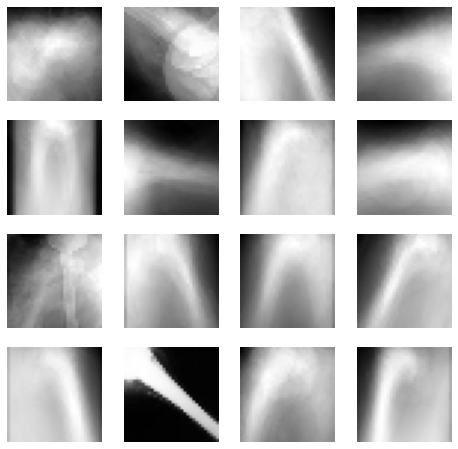

In [89]:
plot_helper(mus)

You can also plot samples in each cluster. Do you see any patterns? 

Visualizing cluster 0


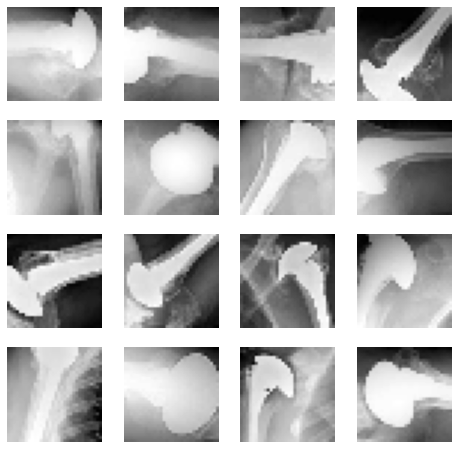

Visualizing cluster 1


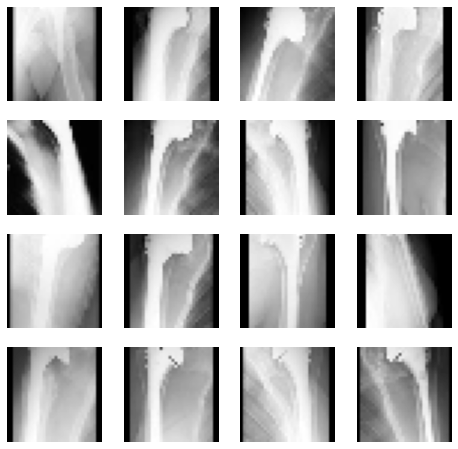

Visualizing cluster 2


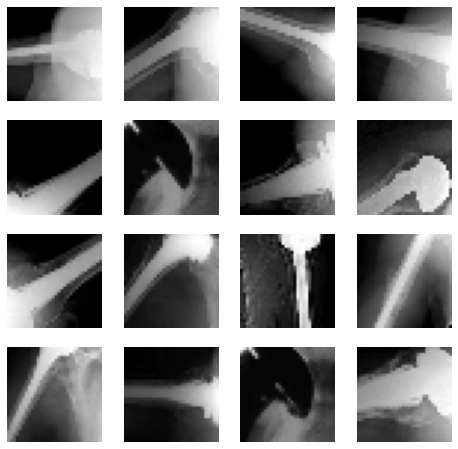

Visualizing cluster 3


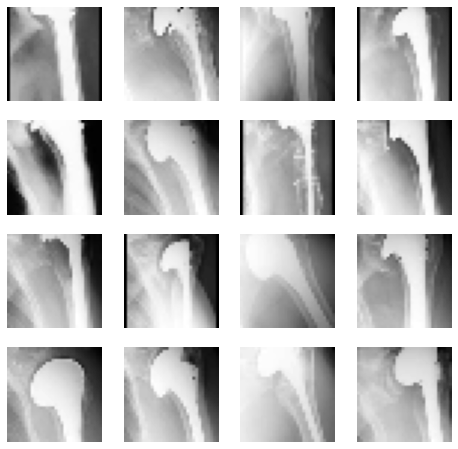

In [90]:
for k in range(4):
    print(f"Visualizing cluster {k}")
    plot_helper(X[clusters==k])
    plt.show()

As a sanity check, the following is an example of a cluster that you might get (though not guaranteed due to the randomnness at initialization):  

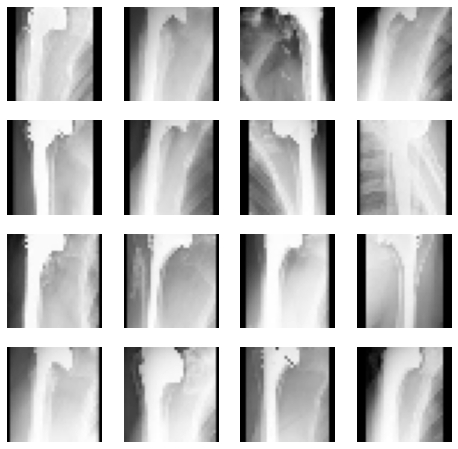

## Autograder

In [91]:
grader.grade(test_case_id = 'kmeans_init', answer = kmeans_init)
grader.grade(test_case_id = 'kmeans_assign', answer = kmeans_assign_clusters)
grader.grade(test_case_id = 'kmeans_update_centroids', answer = kmeans_update_centroids)
grader.grade(test_case_id = 'kmeans_stopping_condition', answer = kmeans_stopping_criteria)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 1.0/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# 2. PCA (6pts)

K-means is one of the simplest clustering algorithms. What about if we used Gaussian Mixture Models (GMMs) instead? Recall that GMMs have an assumption: that the data is drawn from a mixture of Gaussians. The further the data is from this ground truth, the worse the GMM estimate will be. 

It turns out that the raw X-ray data is not drawn from a mixture of Gaussians---in fact, it is so far away that the traditional EM algorithm can't return any reasonable results! This is largely because the image data is too high dimensional, which results in singular covariance matrices.  

However, we have a tool to deal with large dimensions: we can fix this with PCA! In this second part, we're going to use PCA to reduce the dimensionality of the X-ray data. 

Implement the following functions:

+ Normalize (2pts) - Given a batch of examples  $X$, normalize the examples to have zero mean and unit variance along each feature. 
+ Fit PCA (2pts) - Given a batch of examples $X$ and an integer $k$, calculate the top $k$ PCA basis vectors. 
+ Transform PCA (1pt) - Given a batch of examples $X$ and $k$ PCA basis vectors, transform the examples $X$ into the space spanned by the PCA basis vectors. 
+ Reconstruction PCA (1pt) - Given a batch of exmaples $X$ and $k$ PCA basis vectors, calculate the best reconstruction of the examples $X$ from the PCA basis vectors. 

In [92]:


def normalize(X):
    # Given a batch of examples 𝑋, normalize the examples to have zero mean 
    # and unit variance along each feature.
    # 
    # X := Tensor(float) of size (m,d) --- Batch of m examples of dimension d
    # 
    # Return := Tensor of size (m,d) --- Normalized X along each feature 

    # Fill in the rest
    return (X - torch.mean(X, 0)) / torch.std(X, 0)

def pca_fit(X,k): 
    # Given a batch of examples 𝑋 and an integer 𝑘, calculate the top  
    # 𝑘 PCA basis vectors.
    # 
    # X := Tensor(float) of size (m,d) --- Batch of m examples of dimension d
    #
    # Return := Tensor of size (d, k) - The first `k` eigenvectors of the 
    #       covariance matrix of `X`

    eigvals, eigvectors = torch.linalg.eig(X.T @ X / X.shape[0])
    indices = torch.sort(eigvals.real, descending=True).indices[:k]

    return eigvectors.real[:, indices]

def pca_transform(X,V): 
    # Given a batch of examples 𝑋 and 𝑘 PCA basis vectors, transform the 
    # examples 𝑋 into the space spanned by the PCA basis vectors.
    #
    # X := Tensor (float) of size (m, d) - Batch of m examples of dimension d
    #
    # V := Tensor (float) of size (d, k) - First `k` principal components to 
    #       use for the transformation
    #
    # Return := Tensor of size (m, k) - Transformed version of `X` projected 
    #       onto the first `k` principal components represented by `V`

    # Fill in the rest 
    return torch.matmul(X, V)

def pca_reconstruction(X,V): 
    # Given a batch of examples 𝑋 and 𝑘 PCA basis vectors, calculate the 
    # best reconstruction of the examples 𝑋 from the PCA basis vectors
    #
    # X := Tensor (float) of size (m, d) - Batch of m examples of dimension d 
    #
    # V := Tensor (float) of size (d, k) - The first `k` principal components 
    #       used for the reconstruction
    #
    # Return := Tensor of size (m, d) - Reconstructed version of the original 
    #       data `X`

    # Fill in the rest
    return X @ V @ V.T


Test your code in the following cell. Plot the reconstruction error as a function of $k$. 


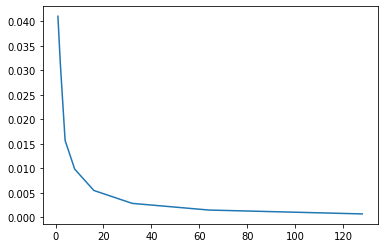

In [93]:
# Plot reconstruction error as a function of k
ks = [2**i for i in range(8)]
losses = []
for k in ks: 
    V = pca_fit(normalize(X),k)
    pca_X = pca_reconstruction(X,V)
    pca_error = F.mse_loss(pca_X,X)
    losses.append(pca_error.item())
plt.plot(ks,losses)

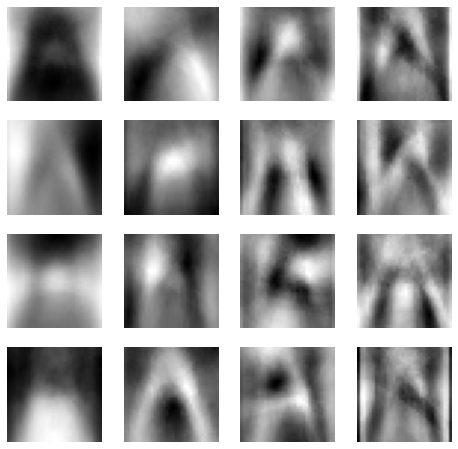

In [94]:
# visualize the top k PCA basis vectors 

n0 = 4
fig, axs = plt.subplots(n0, n0, figsize=(8,8))
for i in range(n0*n0): 
    axs[i%n0,i//n0].imshow(V[:,i].view(32,32), cmap='gray')
    axs[i%n0,i//n0].axis('off')

You should get something like the following for reconstruction error and basis vectors: 


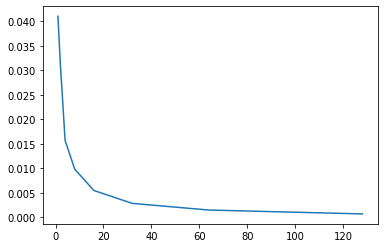

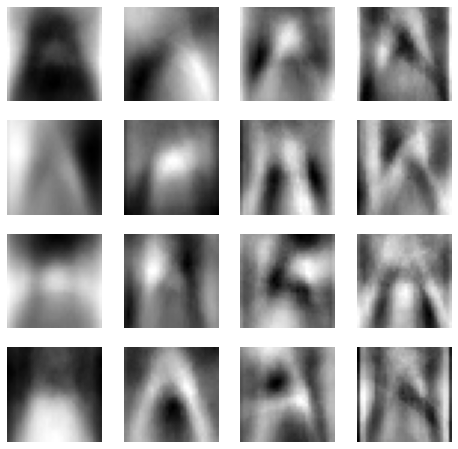

## Autograder

In [95]:
grader.grade(test_case_id = 'pca_normalize', answer = normalize)
grader.grade(test_case_id = 'pca_fit', answer = pca_fit)
grader.grade(test_case_id = 'pca_transform', answer = pca_transform)
grader.grade(test_case_id = 'pca_reconstruction', answer = pca_reconstruction)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# 3. GMM and EM (17pts)

Now that we have our data living in a lower dimensional space, we are now ready to implement the EM algorithm for GMMs. Implement the following: 

+ E-step (4pts) - Given a batch of examples $X$ and estimates for the cluster proportions $\pi$, cluster means $\mu$, and covariances $\Sigma$, calculate the soft cluster assignments (i.e. the probability of a cluster given an example). 
+ M-step (9pts) - Given a batch of examples $X$ and the soft cluster assignments $\Gamma$, calculate new estimates for the GMM parameters. 
+ EM negative log likelihood (2pts) - Given a batch of examples $X$ and the GMM parameters $(\pi, \mu, \Sigma)$, calculate the negative log likelihood. 
+ EM stopping criteria (1pt) - Given the negative log likelihood of the current and previous iteration, return True if the loss has not improved by more than the provided tolerance level. 
+ EM clusters (1pt) - Given the soft cluster assignments $\Gamma$, make a hard assignment of examples to the cluster with the highest likelihood. 

In [96]:
def E_step(X, pis, mus, Covs): 
    # Given a batch of examples X and estimates for the cluster proportions pi, cluster means mu, and 
    # covariances Covs, calculate the soft cluster assignments (i.e. the probability of a cluster given an example).
    # 
    # X: Tensor(float) of size(m, d) --- batch of m examples with dimension d
    # pis := Tensor(float) of size(k,) --- This is the weight of each cluster
    # mus := Tensor(float) of size(k, d) --  This is the cluster means for the k clusters
    # Covs := Tensor(float) of size(k, d, d) -- This is the covariance parameter of the Gaussian distribution
    # 
    # Return := Tensor(float) of size(m, k) -- This is the result of the E step that calculates the probability 
    #       of a cluster given an example
    # 
    m = X.shape[0]
    k = pis.shape[0]

    # x is the data and l is the index of cluster (there are k clusters)
    def prob(x, l):
      mulnormal_dist = torch.distributions.multivariate_normal.MultivariateNormal(mus[l], Covs[l])
      return torch.exp(mulnormal_dist.log_prob(x))

    res = torch.empty(m, k)

    for i in range(m):
      probs = torch.empty(k)
      for l in range(k): 
        probs[l] = prob(X[i], l)
      weighted_probs = probs * pis
      # print(weighted_probs)
      sum_weighted_probs = weighted_probs.sum(dim = -1).unsqueeze(-1)
      res[i] = weighted_probs / sum_weighted_probs
    
    return res


def M_step(X, Gamma):
    # Given a batch of example X and the soft cluster assignment gamma, calculate the new estimate of GMM parameters
    # 
    # X := Tensor(float) of size(m, d) --- batch of m examples with dimension d
    # Gamma := Tensor(float) of size(m, k) --- This is the soft cluster assignment 
    # 
    # Return := Updated pis, mus, covs after the EM-Step

    # Fill in the rest 
    m, k = Gamma.shape
    d = X.shape[1]

    pis = torch.sum(Gamma, 0) / m

    mus = torch.sum(Gamma.T.unsqueeze(2).repeat(1, 1, d) * X, 1) \
        / torch.sum(Gamma, 0).unsqueeze(1).repeat(1, d)

    mu = X.unsqueeze(2).repeat(1, 1, k) - mus.T.unsqueeze(0).repeat(m, 1, 1)
    mu_t = mu.transpose(0, 2).transpose(1, 2)
    # print(mu_t.shape)
    gamma = Gamma.T.unsqueeze(2).repeat(1, 1, d)
    # print(gamma.shape)
    numerator = torch.matmul(mu.transpose(0, 2), mu_t * gamma)
    denominator = torch.sum(Gamma, 0).unsqueeze(1).unsqueeze(2).repeat(1, d, d)

    return pis, mus, numerator / denominator

def EM_neg_log_likelihood(X, pis, mus, Covs): 
    # Given a batch of examples X and the GMM parameters (pi, mu, sigma), calculate the negative log likelihood. 
    # 
    # X: Tensor(float) of size(m, d) --- batch of m examples with dimension d
    # pis := Tensor(float) of size(k,) --- This is the weight of each cluster
    # mus := Tensor(float) of size(k, d) --  This is the cluster means for the k clusters
    # Covs := Tensor(float) of size(k, d, d) -- This is the covariance parameter of the Gaussian distribution
    # 
    # Return := Tensor(float) of size(m, ) -- returns the loss

    # np.sum(np.log(np.sum(W, axis = 1)))
    # Fill in the rest 
    return -sum([k*torch.distributions.multivariate_normal.MultivariateNormal(mus[i],Covs[j]).log_prob(X) for k,i,j in zip(pis,range(len(mus)),range(len(Covs)))])

def EM_stopping_criteria(nll, nll_prev, tol=1e-4): 
    # Given the negative log likelihood of the current and previous iteration, 
    # return True if the loss has not improved by more than the provided tolerance level. 

    # nll := Tensor(float) of size(m,) -- The negative log likelihood after the EM update
    # nll_prev := Tensor(float) of size(m,) -- The negative log likelihood before the update
    # tol := float -- the provided tolerance level for EM's stopping condition
    # 
    # Return := Tensor(bool) of size (1,) --- return true if the loss has not improved by more 
    # than the provided tolerance level

    # Fill in the rest 
    diff = torch.sum(nll) - torch.sum(nll_prev)
    criteria = diff > tol
    # print(criteria)
    return criteria.unsqueeze(0)

def EM_clusters(Gamma): 
    # Given the soft cluster assignments Gamma,
    # make a hard assignment of examples to the cluster with the highest likelihood. 
    # 
    # Gamma := Tensor(float) of size(m, k) --- This is the soft cluster assignment 
    # 
    # Return := Tensor(float) of size(m,) -- The hard cluster assignments of the examples

    # Fill in the rest 
    return torch.max(Gamma, dim=1).indices

Test your code on the the PCA encoding of the X-ray data. Here, we're using 16 PCA basis vectors and allowing for a mixture of 8 Gaussians, but you can play around with these numbers. 

In [97]:
X_gmm = pca_transform(X, pca_fit(X,16))
k = 8
niters = 50
d = X_gmm.size(1)

pis = torch.ones(k)/k
mus = kmeans_init(X_gmm,k)
Covs = torch.stack([torch.eye(d) for _ in range(k)],dim=0)

nll = None
for t in range(niters): 
    prev_nll = nll

    Gamma = E_step(X_gmm, pis, mus, Covs)
    pis, mus, Covs = M_step(X_gmm, Gamma)
    Covs = Covs + 1e-4*torch.eye(d) # add some regularization 
    
    nll = EM_neg_log_likelihood(X_gmm, pis, mus, Covs)
    if t % 5 == 0: 
        print(t, nll.mean().item())
    if prev_nll is not None and EM_stopping_criteria(nll, prev_nll): 
        break
        
print(f"Ended after {t} iterations.")
clusters = EM_clusters(Gamma)

0 64.36316680908203
Ended after 1 iterations.


If successful, you should get some nice visually similar clusters: 

Visualizing cluster 0


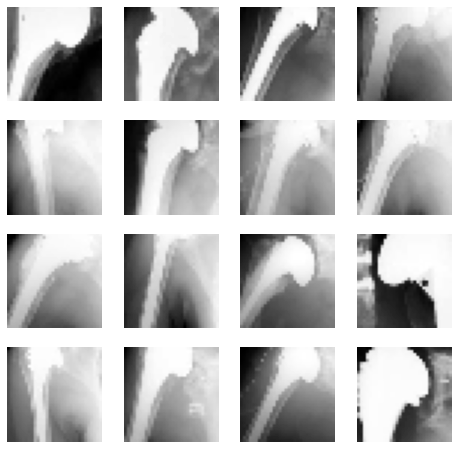

Visualizing cluster 1


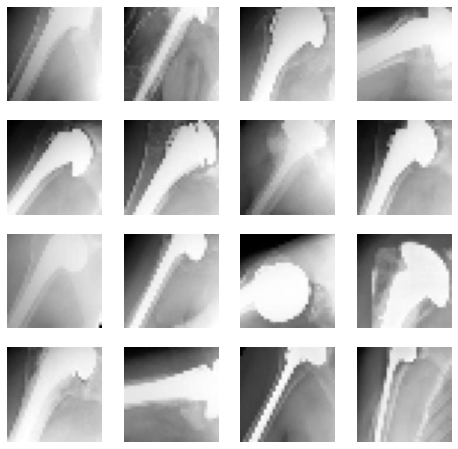

Visualizing cluster 2


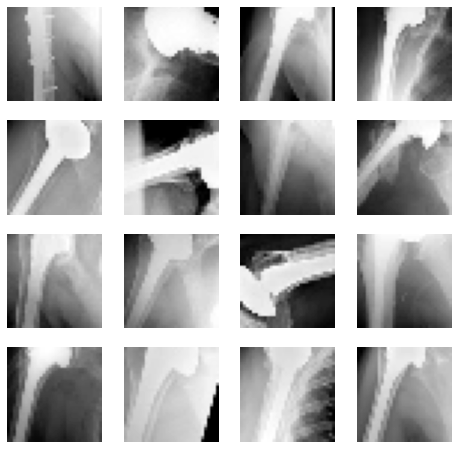

Visualizing cluster 3


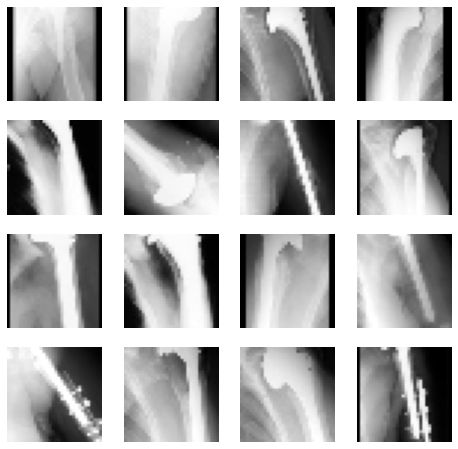

In [98]:
for k in range(4):
    if (clusters == k).sum() >= 16: 
        print(f"Visualizing cluster {k}")
        plot_helper(X[clusters==k])
        plt.show()

For example, one possible cluster you might discover is the following: 

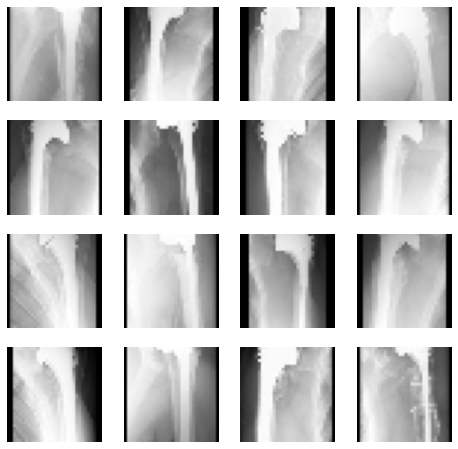

## Autograder

In [99]:
grader.grade(test_case_id = 'E_step', answer = E_step)
grader.grade(test_case_id = 'M_step', answer = M_step)
grader.grade(test_case_id = 'EM_neg_log_likelihood', answer = EM_neg_log_likelihood)
grader.grade(test_case_id = 'EM_stopping_criteria', answer = EM_stopping_criteria)
grader.grade(test_case_id = 'EM_clusters', answer = EM_clusters)

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 9/9 points. You are a star!

Your submission has been successfully recorded in the gradebook.
You earned 0/2 points.

But, don't worry you can re-submit and we will keep only your latest score.
Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# Submitting to Gradescope
Before submitting to Gradescope, make sure that selecting "Runtime" -> "Restart and run all" completes all cells without errors. 

1. Go to the File menu and choose "Download .ipynb" and also "Download .py". Make sure these files are named homework2.ipynb and homework1.py, respectively
2. Go to GradeScope through the canvas page and ensure your class is "BAN_CIS-5200-001 202310"
3. Select Homework 2
4. Upload both files (the .ipynb and the .py)
5. PLEASE CHECK THE AUTOGRADER OUTPUT TO ENSURE YOUR SUBMISSION IS PROCESSED CORRECTLY! If this is the case, you should be all set with the programming component of this homework!